## 1. Setup and Getting Data

#### 1.1 Libraries

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


#### 1.2 Data

In [10]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [12]:
cap = cv2.VideoCapture(1)
if cap.isOpened():
    for imgnum in range(number_images):
        print(f"Collecting Image {imgnum}")
        ret, frame = cap.read()
        imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
        time.sleep(0.5)
    
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

#### 1.3 Annotating

In [13]:
!labelme

2024-02-17 23:14:19,077 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\arnav\.labelmerc


## 2. Reviewing Dataset and Build Image Loading Function

#### 2.1 Libraries

In [11]:
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

#### 2.2 Limit GPU Memory Growth

In [15]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [16]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

#### 2.3 load Image into TF Data Pipeline

In [17]:
images = tf.data.Dataset.list_files("data\\images\\*.jpg", shuffle=True)

In [18]:
images.as_numpy_iterator().next()

b'data\\images\\f9665883-cdbb-11ee-bacf-70cf4994687f.jpg'

In [3]:
def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [20]:
images = images.map(load_images)

In [21]:
images.as_numpy_iterator().next()

array([[[ 22,  18,   9],
        [ 21,  17,   8],
        [ 19,  15,   6],
        ...,
        [100, 105, 109],
        [100, 105, 109],
        [100, 105, 109]],

       [[ 19,  15,   6],
        [ 23,  19,  10],
        [ 23,  19,  10],
        ...,
        [100, 105, 109],
        [100, 105, 109],
        [100, 105, 109]],

       [[ 16,  12,   3],
        [ 24,  20,  11],
        [ 27,  23,  14],
        ...,
        [101, 106, 110],
        [101, 106, 110],
        [101, 106, 110]],

       ...,

       [[ 26,  18,   7],
        [ 25,  19,   7],
        [ 26,  18,   7],
        ...,
        [ 35,  30,  24],
        [ 32,  27,  21],
        [ 30,  25,  19]],

       [[ 27,  17,   7],
        [ 26,  18,   7],
        [ 27,  17,   7],
        ...,
        [ 11,   8,   1],
        [ 10,   7,   0],
        [  9,   6,   0]],

       [[ 29,  19,   9],
        [ 29,  19,   9],
        [ 29,  19,   9],
        ...,
        [ 16,  13,   6],
        [ 17,  14,   7],
        [ 18,  15,   8]]

In [22]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

#### 2.4 View Raw Images with Matplotlib

In [23]:
image_generator=images.batch(4).as_numpy_iterator()

In [26]:
plot_images = image_generator.next()

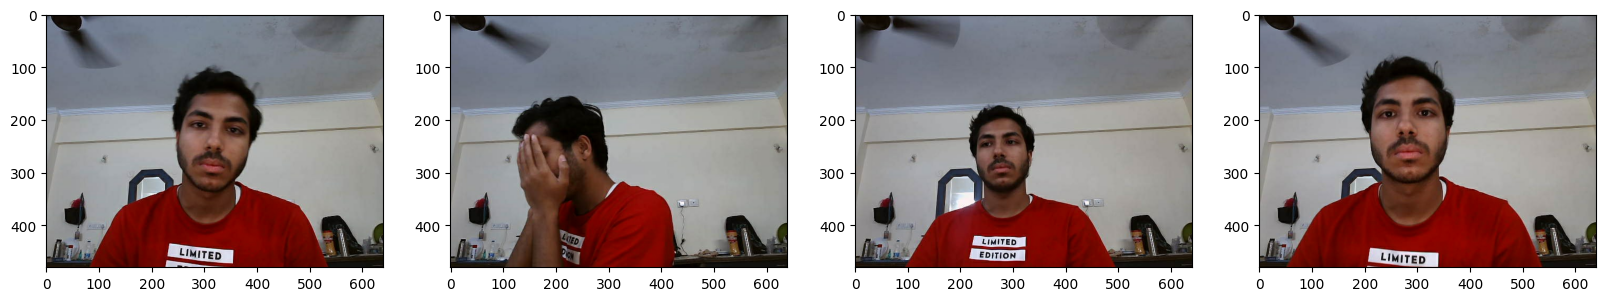

In [27]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 3. Partition Unaugmented Data

#### 3.1 Manually split data into Train, Test and Val

In [43]:
90*.7 #63 to train

62.99999999999999

In [44]:
90*.15 # 14 and 13 to test and val

13.5

In [28]:
import os
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels using Albumentations

#### 4.1 Building the Augmentor

In [4]:
import albumentations as alb

In [30]:
augmentor = alb.Compose([alb.RandomCrop(width = 450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

#### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [33]:
img = cv2.imread(os.path.join('data','train','images','077f57a2-cdbc-11ee-89d6-70cf4994687f.jpg'))

In [34]:
img.shape

(480, 640, 3)

In [36]:
with open(os.path.join('data','train','labels','077f57a2-cdbc-11ee-89d6-70cf4994687f.json'), 'r') as f:
    label = json.load(f)

In [37]:
label['shapes'][0]['points']

[[157.39837398373987, 117.23577235772358],
 [331.38211382113826, 347.3170731707317]]

#### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [38]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [39]:
coords

[157.39837398373987, 117.23577235772358, 331.38211382113826, 347.3170731707317]

In [40]:
coords = list(np.divide(coords, [640,480,640,480]))

In [41]:
coords

[0.24593495934959356,
 0.24424119241192413,
 0.5177845528455285,
 0.7235772357723577]

#### 4.4 Apply Augmentations and View Results

In [42]:
augmented = augmentor(image = img, bboxes=[coords], class_labels=['face'])

In [68]:
augmented['bboxes'][0][:2]

(0.11644083107497749, 0.2881842818428184)

In [70]:
augmented['bboxes'][0][2:]

(0.5030713640469738, 0.7994760614272809)

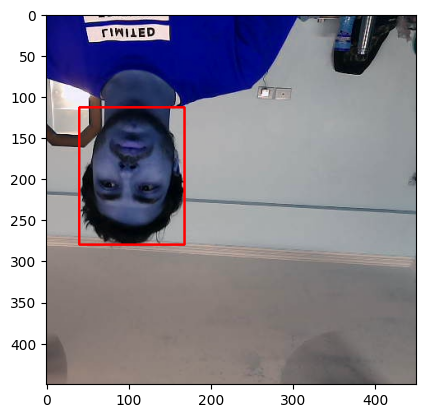

In [159]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0), 2)

plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline

#### 5.1 Run Augmentation Pipeline

In [77]:
for partition in ['train','test','val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


#### 5.1 Load Augmented Images to Tensorflow Dataset

In [5]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle = False)
train_images = train_images.map(load_images)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle = False)
test_images = test_images.map(load_images)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle = False)
val_images = val_images.map(load_images)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [8]:
train_images.as_numpy_iterator().next()

array([[[0.06813726, 0.05698529, 0.01819853],
        [0.07352941, 0.05030637, 0.01372549],
        [0.0759804 , 0.05882353, 0.02794118],
        ...,
        [0.38431373, 0.3882353 , 0.40392157],
        [0.3877451 , 0.39166668, 0.40735295],
        [0.39699754, 0.4009191 , 0.4190564 ]],

       [[0.08155637, 0.06734069, 0.05606618],
        [0.08915441, 0.07493872, 0.06366421],
        [0.09607843, 0.08186275, 0.07058824],
        ...,
        [0.38431373, 0.3882353 , 0.40392157],
        [0.39215687, 0.39607844, 0.4117647 ],
        [0.40422794, 0.4081495 , 0.42628676]],

       [[0.15116422, 0.15116422, 0.14332108],
        [0.15925245, 0.15925245, 0.15140931],
        [0.1627451 , 0.1627451 , 0.1627451 ],
        ...,
        [0.39264706, 0.39656863, 0.4122549 ],
        [0.39607844, 0.4       , 0.41568628],
        [0.4117647 , 0.41568628, 0.43382353]],

       ...,

       [[0.31617647, 0.00637255, 0.        ],
        [0.31807598, 0.01476716, 0.        ],
        [0.32156864, 0

## 6. Prepare Labels

#### 6.1 Build Label Loading Function

In [9]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

#### 6.2 Load Labels to Tensorflow Dataset

In [10]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)

In [11]:
train_labels.as_numpy_iterator().next()

b'aug_data\\train\\labels\\077f57a2-cdbc-11ee-89d6-70cf4994687f.0.json'

In [12]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [13]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [14]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0898, 0.2428, 0.4763, 0.754 ], dtype=float16))

## 7. Combine Label and Image Samples

#### 7.1 Check Partition Samples

In [16]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_labels), len(val_images)

(3780, 3780, 840, 840, 780, 780)

#### 7.2 Create Final Datasets (Images/Labels)

In [17]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [18]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [19]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [20]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.1068 , 0.3943 , 0.3706 , 0.725  ],
        [0.03958, 0.2756 , 0.372  , 0.704  ],
        [0.271  , 0.3457 , 0.708  , 0.9526 ],
        [0.286  , 0.2515 , 0.819  , 0.9346 ],
        [0.5234 , 0.3167 , 0.8955 , 0.821  ],
        [0.     , 0.2612 , 0.3699 , 0.765  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.4678 , 0.257  , 0.8345 , 0.718  ]], dtype=float16))

#### 7.3 View Images and Annotations

In [21]:
data_samples = train.as_numpy_iterator()

In [22]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


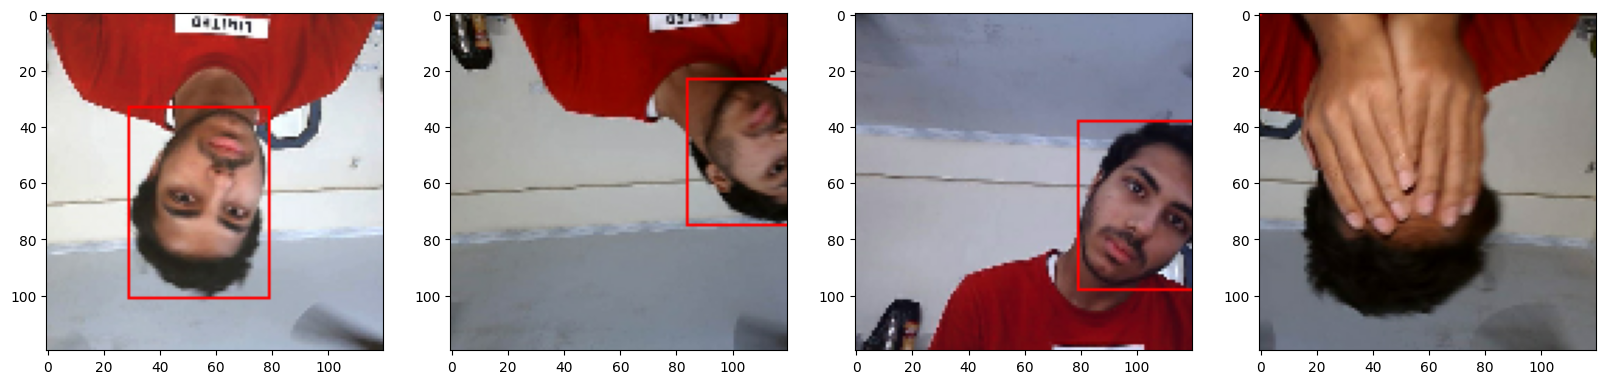

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx].copy()
    sample_coords = res[1][1][idx]

    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                  (255,0,0), 1)

    ax[idx].imshow(sample_image)

## 8. Build Deep Learning using the Functional API

#### 8.1 Import Layers and Base Network

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

#### 8.2 Download VGG16

In [25]:
vgg = VGG16(include_top=False)

In [26]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

#### 8.3 Build Instance of Network

In [27]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    #Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)

    #Bounding Box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4,activation='sigmoid')(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out Neural Network

In [28]:
facetracker = build_model()

In [29]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [30]:
X, y = train.as_numpy_iterator().next()

In [31]:
X.shape

(8, 120, 120, 3)

In [32]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 488ms/step


In [33]:
classes, coords

(array([[0.6223062 ],
        [0.50591695],
        [0.554744  ],
        [0.41982043],
        [0.4393974 ],
        [0.45942783],
        [0.40695068],
        [0.4011161 ]], dtype=float32),
 array([[0.45178208, 0.38530862, 0.45538488, 0.38453004],
        [0.40458873, 0.44444966, 0.39402422, 0.41084218],
        [0.47290373, 0.47061235, 0.42867437, 0.33747765],
        [0.51146364, 0.4781294 , 0.48370773, 0.38809693],
        [0.52871525, 0.4676332 , 0.4357393 , 0.31635892],
        [0.6276847 , 0.45741966, 0.3861659 , 0.27467805],
        [0.5656154 , 0.40446493, 0.46337375, 0.42025545],
        [0.5296236 , 0.45625758, 0.5199995 , 0.3046196 ]], dtype=float32))

## 9. Define Losses and Optimizers

#### 9.1 Define Optimizer and LR

In [34]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [35]:
lr_decay

0.0007047216349541929

In [36]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

#### 9.2 Create Localization Loss and Classification Loss

In [37]:
def localization_loss(y_true, yhat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = yhat[:,3] - yhat[:,1]
    w_pred = yhat[:,2] - yhat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))

    return delta_coord + delta_size

In [38]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

#### 9.3 Test out Loss Metrics

In [39]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.7613482>

In [40]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6626557>

In [41]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.7613482>

## 10. Train Neural Network

#### 10.1 Create Custom Model Class

In [48]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):

        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss+0.5*batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)

        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss    

        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [49]:
model = FaceTracker(facetracker)

In [50]:
model.compile(opt, classloss, regressloss)

#### 10.2 Train

In [51]:
logdir = 'logs'

In [52]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [53]:
hist = model.fit(train, epochs = 40, validation_data = val, callbacks=[tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 432s 905ms/step - total_loss: 0.0379 - class_loss: 0.0114 - regress_loss: 0.0322 - val_total_loss: 0.5001 - val_class_loss: 0.5747 - val_regress_loss: 0.2128
Epoch 2/40
473/473 [==============================] - 450s 942ms/step - total_loss: 0.0254 - class_loss: 0.0058 - regress_loss: 0.0224 - val_total_loss: 0.0115 - val_class_loss: 9.9393e-06 - val_regress_loss: 0.0115
Epoch 3/40
473/473 [==============================] - 456s 957ms/step - total_loss: 0.0137 - class_loss: 0.0055 - regress_loss: 0.0110 - val_total_loss: 0.0063 - val_class_loss: 3.0847e-05 - val_regress_loss: 0.0063
Epoch 4/40
473/473 [==============================] - 521s 1s/step - total_loss: 0.0093 - class_loss: 0.0030 - regress_loss: 0.0078 - val_total_loss: 0.0027 - val_class_loss: 8.5270e-05 - val_regress_loss: 0.0027
Epoch 5/40
473/473 [==============================] - 503s 1s/step - total_loss: 0.0083 - class_loss: 0.0035 - regress_loss: 0.0065 - val_total

#### 10.3 Plot Performance

In [57]:
hist.history

{'total_loss': [0.080747589468956,
  0.00387451215647161,
  0.0014021643437445164,
  0.002158235991373658,
  0.0009185819653794169,
  0.0009903477039188147,
  0.0010629626922309399,
  0.0012788421008735895,
  0.0013124644756317139,
  0.0009002843871712685,
  0.0008851594175212085,
  0.0005192995304241776,
  0.00038370778202079237,
  0.00043428197386674583,
  0.0005588999483734369,
  0.0002789012505672872,
  0.0005638535949401557,
  0.0044790408574044704,
  0.00029272204847075045,
  0.0003922576433978975,
  0.00010739168646978214,
  0.00017952379130292684,
  0.00039792765164747834,
  0.00018997243023477495,
  0.0017377347685396671,
  0.0007565077976323664,
  0.00015042853192426264,
  0.0003137165040243417,
  0.00018463286687619984,
  0.00010475851740920916,
  0.00024611153639853,
  9.566913831804413e-06,
  0.00028354598907753825,
  0.0001540440134704113,
  0.00022245098080020398,
  0.00016212165064644068,
  0.00030740402871742845,
  0.0002328550472157076,
  0.00012097579019609839,
  9.4

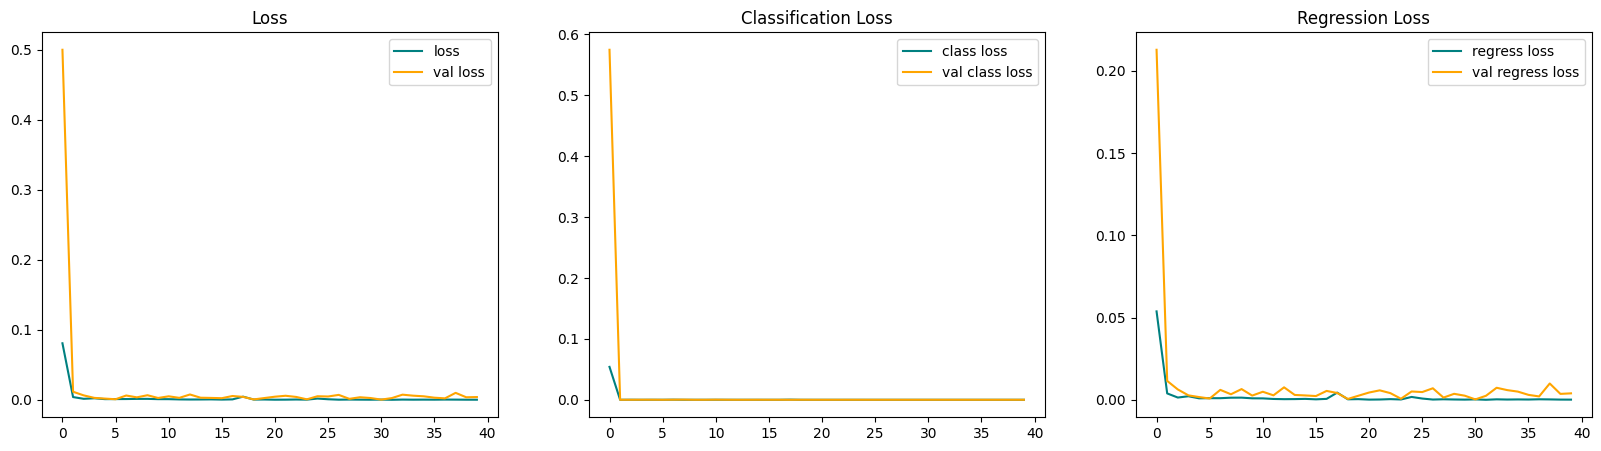

In [58]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions

#### 11.1 Make Prediction on Test Set

In [59]:
test_data = test.as_numpy_iterator()

In [1]:
test_sample = test_data.next()

NameError: name 'test_data' is not defined

In [91]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 225ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


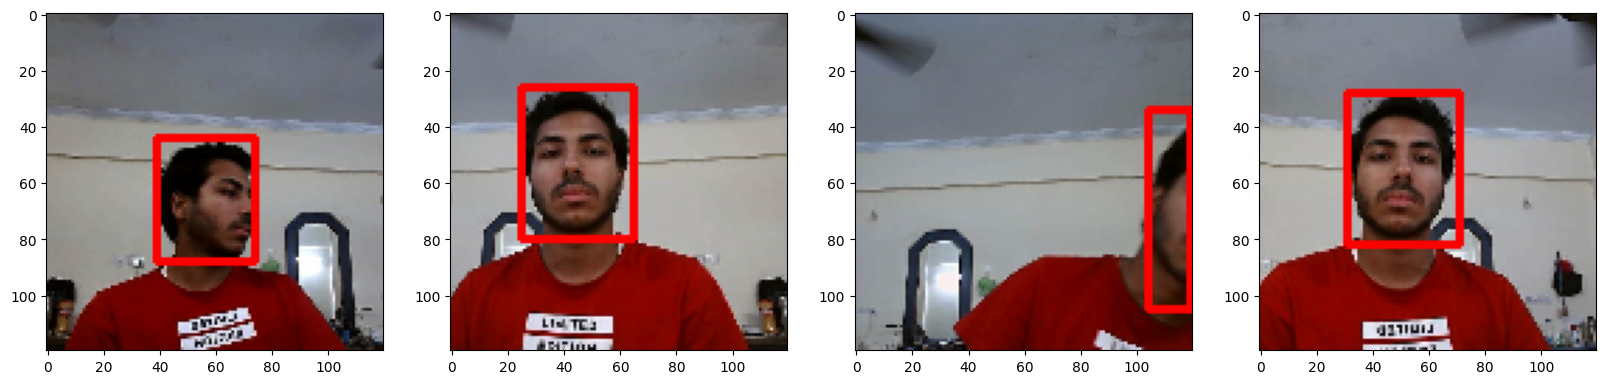

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx].copy()
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                      tuple(np.multiply(sample_coords[:2],[120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:],[120,120]).astype(int)),
                      (255,0,0), 2)
    ax[idx].imshow(sample_image)

## 11.2 Save the Model

In [3]:
from tensorflow.keras.models import load_model

In [95]:
facetracker.save('facetracker.h5')

C:\Users\arnav\OneDrive\Desktop\FaceRec\myenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
facetracker = load_model('facetracker.h5')

#### 11.3 Real Time Detection

In [29]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]

    if yhat[0] > 0.5:
        cv2.rectangle(frame,
                      tuple(np.multiply(sample_coords[:2],[450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:],[450,450]).astype(int)),
                      (255,0,0), 2)
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),[0,-30])),
                      tuple(np.add(np.multiply([sample_coords[2],sample_coords[1]],[450,450]).astype(int),[0,0])),
                      (255,0,0), -1)
        cv2.putText(frame, 'face', 
                    tuple(np.add(np.multiply(sample_coords[:2],[450,450]).astype(int),[0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 69ms/step
